In [1]:
%pylab inline
import os
import gc
import scipy
import fitsio
import smatch
import numpy as np
from fpfs import simutil
import astropy.table as astTable

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
cosmo252=simutil.cosmoHSTGal('252')
cosmo252.readHSTsample()

In [26]:
# COSMO2020
fname=os.path.join(os.environ['homeWrk'],'COSMOS/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.1_p3.fits')
data=astTable.Table.read(fname)
data=data[(data['lp_zBEST']>0.)&(data['lp_zBEST']<8.)]

In [27]:
# L2007
fname=os.path.join(os.environ['homeWrk'],'COSMOS/Leauthaud2007/acs_clean_only.fits')
data2=astTable.Table.read(fname)
msk=(data2['MU_CLASS']==1)&(data2['NEARSTAR']==1)&(data2['MASKED']==1)&(data2['GOOD']==1)
msk=msk&(data2['MAG_AUTO']<30.)&(data2['MAG_AUTO']>14.5)
data2=data2[msk]

4083

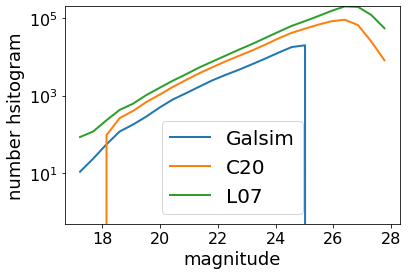

In [28]:
# Galsim catalog
cat=astTable.Table(cosmo252.catused)
bds=np.linspace(17,28,25)
bdc=(bds[1:]+bds[:-1])/2.
nums,bds=np.histogram(cat['mag_auto'],bins=bds,density=False)
nums2,bds2=np.histogram(data['ACS_F814W_MAG'],bins=bds,density=False)
nums3,bds3=np.histogram(data2['MAG_AUTO'],bins=bds,density=False)

plt.close()
plt.plot(bdc,nums,label='Galsim')
plt.plot(bdc,nums2,label='C20')
plt.plot(bdc,nums3,label='L07')
plt.yscale('log')
plt.ylim(0.5,2e5)
plt.legend()
plt.xlabel('magnitude')
plt.ylabel('number hsitogram')
gc.collect()

In [29]:
# match between galsim and L07
nside=4096 # healpix nside
# ra,dec,radius in degrees
matches = smatch.match(
        cat['ra'],cat['dec'], 
        0.3/3600.,
        data2['ALPHA_J2000'],data2['DELTA_J2000'],
        nside=nside, maxmatch=1)
matched2=np.zeros(len(data2)).astype(bool)
matched2[matches['i2']]=True
data2u=data2[~matched2]
data2m=data2[matched2]

catold=cat[matches['i1']]
catold['extended']=False

gc.collect()

4490

Text(0, 0.5, 'number hsitogram')

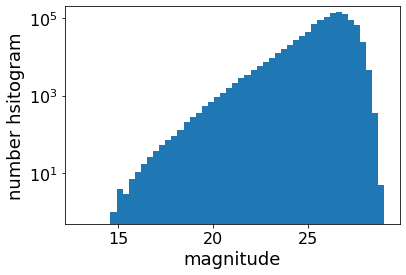

In [30]:
plt.close()
plt.hist(data2u['MAG_AUTO'],bins=50,range=(13,29))
plt.yscale('log')
plt.ylim(0.5,2e5)
plt.xlabel('magnitude')
plt.ylabel('number hsitogram')

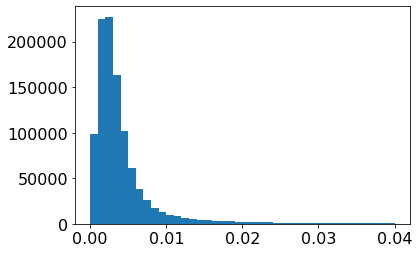

In [31]:
e1M=(data2m['CXX_IMAGE']-data2m['CYY_IMAGE'])/(data2m['CXX_IMAGE']+data2m['CYY_IMAGE'])
e2M=2*data2m['CXY_IMAGE']/(data2m['CXX_IMAGE']+data2m['CYY_IMAGE'])
fwhmM=data2m['FWHM_IMAGE']
absEM=np.sqrt(e1M**2.+e2M**2.)

e1=(data2u['CXX_IMAGE']-data2u['CYY_IMAGE'])/(data2u['CXX_IMAGE']+data2u['CYY_IMAGE'])
e2=2*data2u['CXY_IMAGE']/(data2u['CXX_IMAGE']+data2u['CYY_IMAGE'])
fwhm=data2u['FWHM_IMAGE']
absE=np.sqrt(e1**2.+e2**2.)

stdF=np.sqrt(np.average(fwhm**2.))
stdA=np.sqrt(np.average(absE**2.))

xyRef=np.vstack([absEM/stdA,fwhmM/stdF]).T
xyDat=np.vstack([absE/stdA,fwhm/stdF]).T

tree    =   scipy.spatial.cKDTree(xyRef)
dis,inds=tree.query(xyDat,k=1)

# get the extension
inds_ext=inds[dis<0.02]
catext=catold[inds_ext]
catext['extended']=True
catext2=data2u[dis<0.02]
gc.collect()

plt.close()
_=plt.hist(dis,bins=40,range=(0,0.04))

0


Text(0, 0.5, 'number hsitogram')

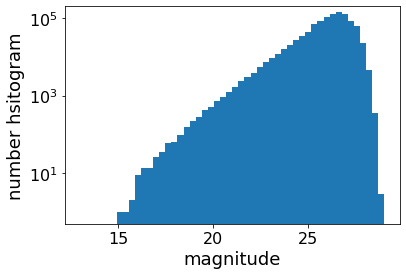

In [32]:
print(len(catext2)-len(catext))
plt.close()
plt.hist(catext2['MAG_AUTO'],bins=50,range=(13,29))
plt.yscale('log')
plt.ylim(0.5,2e5)
plt.xlabel('magnitude')
plt.ylabel('number hsitogram')

In [33]:
# match between extended with COSMOS2020
nside=4096 # healpix nside
# ra,dec,radius in degrees
matches = smatch.match(
        catext['ra'],catext['dec'], 
        0.6/3600.,
        data['ALPHA_J2000'],data['DELTA_J2000'],
        nside=nside, maxmatch=1)
catext=catext[matches['i1']]
catext2=catext2[matches['i1']]
catext3=data[matches['i2']]

In [34]:
gc.collect()
catext['mag_auto']=catext2['MAG_AUTO'].astype(np.dtype('>f8'))
catext['zphot']=catext3['lp_zBEST']
catnew=astTable.vstack([catold,catext])

Text(0, 0.5, 'number hsitogram')

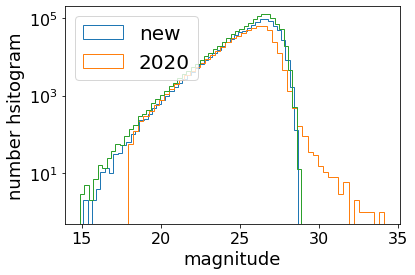

In [44]:
plt.close()
plt.hist(catnew['mag_auto'],bins=50,histtype='step',label='new')
plt.hist(data['ACS_F814W_MAG'],bins=50,histtype='step',label='2020')
plt.hist(data2['MAG_AUTO'],bins=50,histtype='step',label='')
plt.yscale('log')
plt.legend(loc='upper left')
plt.ylim(0.5,2e5)
plt.xlabel('magnitude')
plt.ylabel('number hsitogram')

Text(0, 0.5, 'number hsitogram')

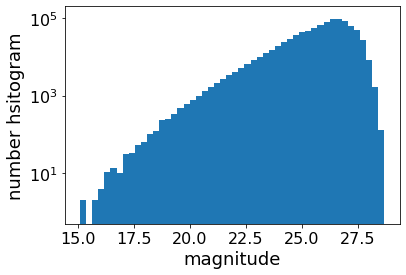

In [48]:
plt.close()
plt.hist(catnew['mag_auto'],bins=50)
plt.yscale('log')
plt.ylim(0.5,2e5)
plt.xlabel('magnitude')
plt.ylabel('number hsitogram')

Text(0, 0.5, 'number hsitogram')

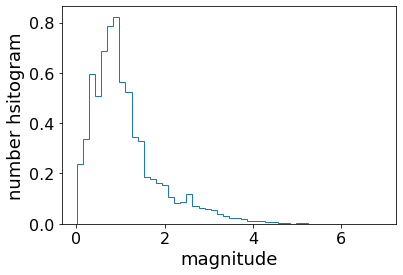

In [66]:
plt.close()
#plt.hist(catext['zphot'],bins=50,histtype='step',density=True)
plt.hist(catext3['lp_zBEST'],bins=50,histtype='step',density=True)
#plt.yscale('log')
#plt.ylim(0.5,2e5)
plt.xlabel('magnitude')
plt.ylabel('number hsitogram')

Text(0, 0.5, 'number hsitogram')

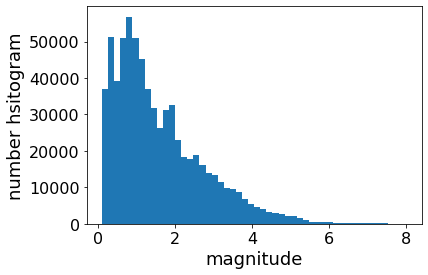

In [69]:
plt.close()
plt.hist(data['lp_zBEST'][data['lp_zBEST']>1e-1],bins=50)
#plt.yscale('log')
#plt.ylim(0.5,2e5)
plt.xlabel('magnitude')
plt.ylabel('number hsitogram')